<a href="https://colab.research.google.com/github/nebaraka/kaggle/blob/main/nlp_with_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("train.csv")

# Visualisation

In [ ]:
!pip install plotly -U

In [26]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from plotly import express as px

In [4]:
import kaleido

#### Class Balance

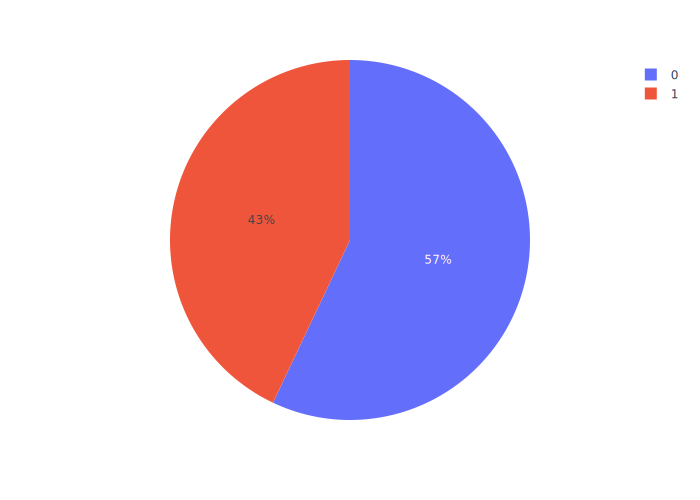

In [5]:
fig = px.pie(df, names="target")
fig.show("svg")

#### Target class distribution among top 5 locations

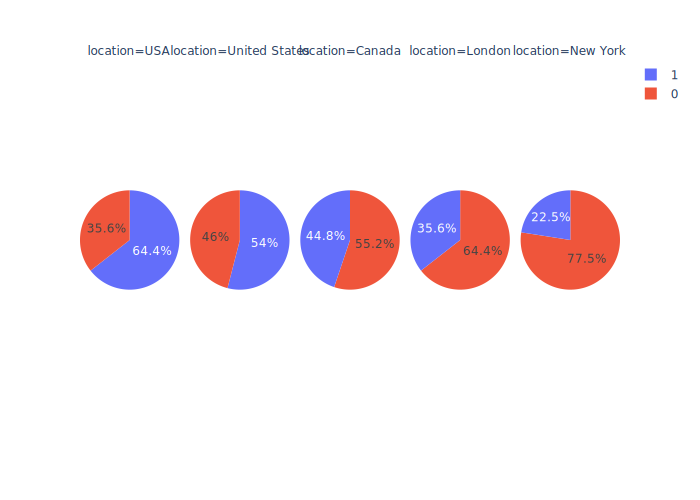

In [6]:
fig = px.pie(df[df.location.apply(lambda x: x in df.location.value_counts().head(5).index.values)], 
             names="target", facet_col="location")
fig.show("svg")

# Modelling

In [4]:
from tqdm.auto import tqdm
tqdm.pandas()

In [5]:
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

In [6]:
!pip install nltk -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import nltk

In [8]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [10]:
import gensim.downloader

In [11]:
text_model = gensim.downloader.load("glove-twitter-100")

In [12]:
def embed_text(text, stemmer, text_model):
    tweets = []
    for tweet in text:
        buffer = []
        for sentence in tweet.split(". "):
            buffer.append(" ".join([stemmer.stem(w) for w in sentence.split(" ")
                                    if w not in set(stopwords.words("english"))]))
        tweets.append(". ".join(buffer))
    tweets = pd.Series(tweets)
    
    return tweets.progress_apply(lambda x: np.mean(
        text_model[[w if w in text_model.index2word # index_to_key
                    else "." 
                    for w in word_tokenize(x)]], axis=0
    ))

In [13]:
text = embed_text(df.text, nltk.PorterStemmer(), text_model)
data = pd.concat([text, df["target"]], axis=1).dropna()

  0%|          | 0/7613 [00:00<?, ?it/s]

In [14]:
data.columns = ["text", "target"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    data["text"], 
    data["target"], stratify=data["target"]
)

## Baseline

In [16]:
y_pred = np.random.choice([0, 1], 
                          size=y_test.shape[0], 
                          p=y_train.value_counts(normalize=True).values)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1086
           1       0.40      0.40      0.40       818

    accuracy                           0.49      1904
   macro avg       0.48      0.48      0.48      1904
weighted avg       0.49      0.49      0.49      1904



## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
# from sklearn.model_selection import GridSearchCV
# optimal parameters were found earlier

In [19]:
model = LogisticRegression(penalty="l2", C=0.12, solver="saga", random_state=1453)
model.fit(np.vstack(X_train.values), y_train)
y_pred = model.predict(np.vstack(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1086
           1       0.78      0.68      0.72       818

    accuracy                           0.78      1904
   macro avg       0.78      0.77      0.77      1904
weighted avg       0.78      0.78      0.77      1904



In [20]:
model = LogisticRegression(penalty="l2", C=16, solver="saga", random_state=1453)
model.fit(np.vstack(data["text"]), data["target"].values)
df_test = pd.read_csv("test.csv")
text_test = embed_text(df_test.text, nltk.PorterStemmer(), text_model)

  0%|          | 0/3263 [00:00<?, ?it/s]

In [21]:
y_pred = model.predict(np.vstack(text_test.apply(lambda x: np.zeros((100)) if pd.isnull(x.sum()) else x)))
answer = pd.DataFrame({"id": df_test["id"], "target": y_pred})
answer.to_csv("submission.csv", index=False)